In [1]:
import optuna
import pandas as pd
import sys

sys.path.append('../../')
from modules.plots import syringeplot

/Users/dylanperdigao/miniforge3/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
configs = [
    ('Net1_CSNN-Base-E5-B128-S20'),
    ('Net1_CSNN-Base-E5-B512-S20'),  
    ('Net1_CSNN-Base-E5-B1024-S20'),
    ('Net1_CSNN-Base-E10-B128-S20'), 
    ('Net1_CSNN-Base-E10-B512-S20'),
    ('Net1_CSNN-Base-E10-B1024-S20'),
    ('Net1_CSNN-Base-E5-B1024-S50'), 
    ('Net1_CSNN-Base-E5-B1024-S10'),

    ('Net2_CSNN-Base-E5-B128-S20'),
    ('Net2_CSNN-Base-E5-B512-S20'),
    ('Net2_CSNN-Base-E5-B1024-S20'),
    ('Net2_CSNN-Base-E10-B128-S20'),
    ('Net2_CSNN-Base-E10-B512-S20'),
    ('Net2_CSNN-Base-E10-B1024-S20'),
    ('Net2_CSNN-Base-E5-B1024-S50'), 
    ('Net2_CSNN-Base-E5-B1024-S10'),

    ('Net3_CSNN-Base-E5-B128-S20'),
    ('Net3_CSNN-Base-E5-B512-S20'),
    ('Net3_CSNN-Base-E5-B1024-S20'),
    ('Net3_CSNN-Base-E10-B128-S20'),
    ('Net3_CSNN-Base-E10-B512-S20'),
    ('Net3_CSNN-Base-E10-B1024-S20'),
    ('Net3_CSNN-Base-E5-B1024-S50'), 
    ('Net3_CSNN-Base-E5-B1024-S10'),
]

In [3]:
dfs = []
for config in configs:
    try:
        study = optuna.load_study(study_name=config, storage=f'sqlite:///../epia2024.db')
        df = study.trials_dataframe()
        df['net'] = f"M{config.split('Net')[1].split('_')[0]}"
        df['epochs'] = int(config.split('E')[1].split('-')[0])
        df['batch_size'] = int(config.split('B')[2].split('-')[0])
        df['steps'] = int(config.split('S')[2].split('-')[0])
        df = df[['net', 'epochs', 'batch_size', 'steps', 'user_attrs_@5FPR recall', 'user_attrs_@5FPR fpr',  'user_attrs_@global recall', 'user_attrs_@global fpr']]
        df['config'] = df.apply(lambda x: f'E={x["epochs"]}\nB={x["batch_size"]}\nS={x["steps"]}', axis=1)
        df = df.drop(columns=['epochs', 'batch_size', 'steps'])
        df = df.rename(columns={'user_attrs_@5FPR recall': 'recall@5fpr', 'user_attrs_@5FPR fpr': 'fpr@5fpr'})
        df = df.rename(columns={'user_attrs_@global recall': 'recall', 'user_attrs_@global fpr': 'fpr'})
        dfs.append(df)
    except Exception as e:
        print(f'Error in {config}: {e}')
        continue
dfs = pd.concat(dfs)
dfs = dfs.dropna()
dfs


,net,recall@5fpr,fpr@5fpr,recall,fpr,config
0,M1,0.000000,0.000000,0.635858,0.153260,E=5\nB=128\nS=20
1,M1,0.000000,0.000000,0.684503,0.172095,E=5\nB=128\nS=20
2,M1,0.193885,0.014916,0.193885,0.014916,E=5\nB=128\nS=20
3,M1,0.000000,0.000000,0.000000,0.000000,E=5\nB=128\nS=20
4,M1,0.184503,0.014911,0.184503,0.014911,E=5\nB=128\nS=20
...,...,...,...,...,...,...
1123,M3,0.000000,0.000000,0.939889,0.631030,E=5\nB=1024\nS=10
1124,M3,0.000000,0.000000,0.685893,0.173618,E=5\nB=1024\nS=10
1125,M3,0.000000,0.000000,0.948575,0.697308,E=5\nB=1024\nS=10
1126,M3,0.000000,0.000000,0.971508,0.742382,E=5\nB=1024\nS=10


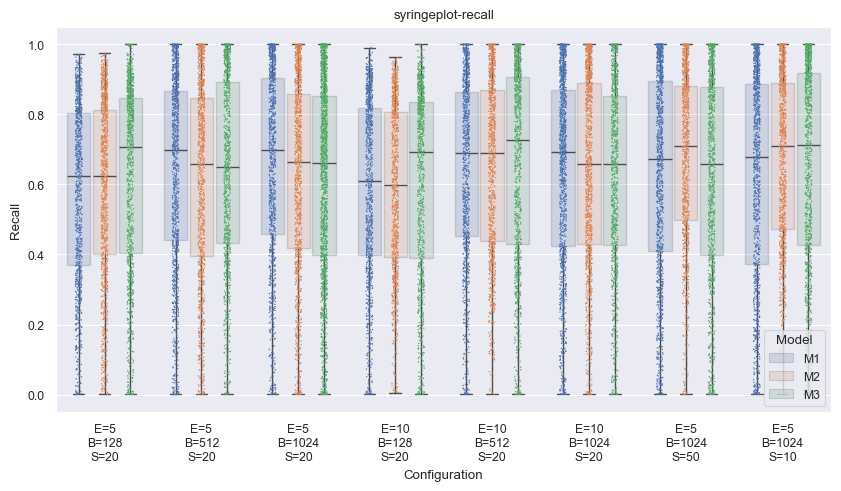

In [4]:
dfs = dfs[dfs['recall'] > 0]
syringeplot(dfs, y='recall', path='./syringeplot', filename="syringeplot-recall.png", title="syringeplot-recall", z_name="Model", text_scale=1, loc='lower right')

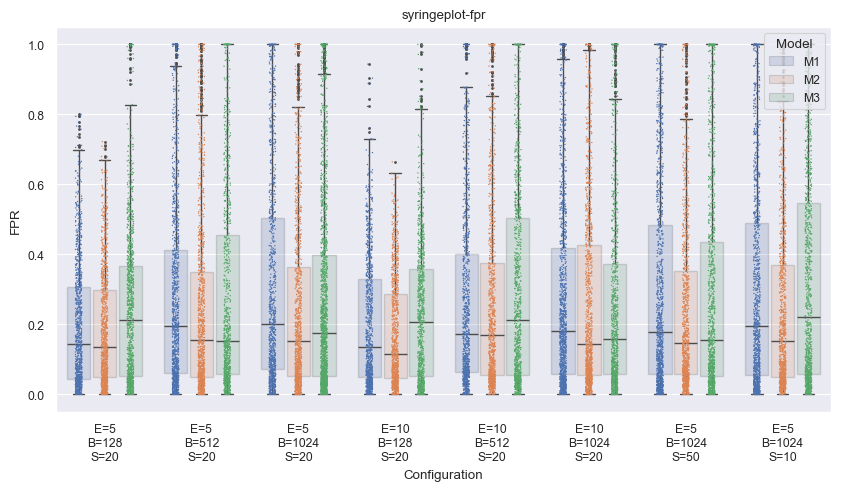

In [5]:
syringeplot(dfs, y='fpr', path='./syringeplot', filename="syringeplot-fpr.png", title="syringeplot-fpr", y_name='FPR', z_name="Model", text_scale=1)

In [6]:
dfs_5fpr = dfs[dfs['recall@5fpr'] > 0]
dfs_5fpr = dfs_5fpr[dfs_5fpr['fpr@5fpr'] <= 0.05]
dfs_bests = dfs_5fpr[(dfs_5fpr['config'] == 'E=5\nB=512\nS=20') | (dfs_5fpr['config'] == 'E=5\nB=1024\nS=50') | (dfs_5fpr['config'] == 'E=10\nB=512\nS=20')]
dfs_bests['config'] = dfs_bests['config'].str.replace('\n', ' / ')
dfs_bests

/var/folders/px/64_j4l_n56x61jstrfywrw4m0000gn/T/ipykernel_92985/3386119730.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_bests['config'] = dfs_bests['config'].str.replace('\n', ' / ')


,net,recall@5fpr,fpr@5fpr,recall,fpr,config
3,M1,0.236623,0.019819,0.236623,0.019819,E=5 / B=512 / S=20
6,M1,0.016678,0.001242,0.016678,0.001242,E=5 / B=512 / S=20
7,M1,0.033704,0.001746,0.033704,0.001746,E=5 / B=512 / S=20
12,M1,0.009034,0.000307,0.009034,0.000307,E=5 / B=512 / S=20
13,M1,0.313760,0.027670,0.313760,0.027670,E=5 / B=512 / S=20
...,...,...,...,...,...,...
1107,M3,0.107019,0.035600,0.107019,0.035600,E=5 / B=1024 / S=50
1114,M3,0.119875,0.008024,0.119875,0.008024,E=5 / B=1024 / S=50
1119,M3,0.295344,0.028966,0.295344,0.028966,E=5 / B=1024 / S=50
1120,M3,0.247741,0.019180,0.247741,0.019180,E=5 / B=1024 / S=50


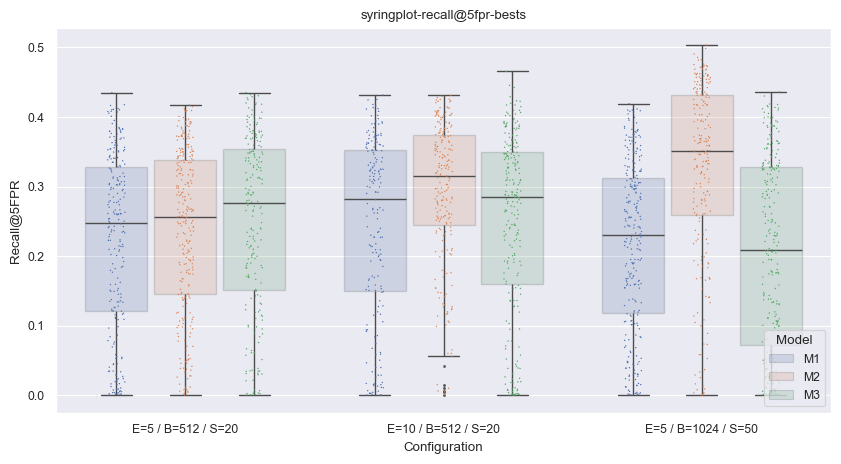

In [7]:
syringeplot(dfs_bests, y='recall@5fpr', path='./syringeplot', filename="syringplot-recall@5fpr-bests.png", title="syringplot-recall@5fpr-bests", y_name='Recall@5FPR', z_name="Model", text_scale=1, loc='lower right')